https://github.com/XanaduAI/quantum-transfer-learning/blob/master/c2q_transfer_learning_cifar.ipynb

In [ ]:
# install the latest released version of PennyLane
!pip install pennylane --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.8 MB/s 
     |████████████████████████████████| 15.3 MB 93.7 MB/s 
     |████████████████████████████████| 145 kB 89.9 MB/s 
     |████████████████████████████████| 1.9 MB 81.1 MB/s 


In [ ]:
# Select one or more quantum frameworks above to install the PennyLane plugins.
!pip install pennylane-lightning pennylane-lightning[gpu] pennylane-sf pennylane-qiskit pennylane-cirq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.3 MB/s 
     |████████████████████████████████| 140 kB 89.9 MB/s 
     |████████████████████████████████| 48 kB 6.7 MB/s 
     |████████████████████████████████| 83 kB 2.9 MB/s 
     |████████████████████████████████| 117 kB 92.0 MB/s 
     |████████████████████████████████| 103 kB 85.2 MB/s 
     |████████████████████████████████| 127 kB 93.2 MB/s 
     |████████████████████████████████| 88 kB 10.1 MB/s 
     |████████████████████████████████| 3.4 MB 64.4 MB/s 
     |████████████████████████████████| 278 kB 87.4 MB/s 
     |████████████████████████████████| 4.8 MB 74.8 MB/s 
     |████████████████████████████████| 240 kB 89.5 MB/s 
     |████████████████████████████████| 12.8 MB 85.1 MB/s 
     |████████████████████████████████| 106 kB 93.7 MB/s 
     |████████████████████████████████| 55 kB 4.8 MB/s 
     |████████████████████████████████

In [ ]:
# Select one or more ML libraries above to install them to work with PennyLane.
# Visit https://pytorch.org/get-started/locally/ for instructions on installing PyTorch.
!pip install autograd tensorflow jax jaxlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import copy

env: OMP_NUM_THREADS=1


In [ ]:
filtered_classes = ['cat', 'dog', 'frog', 'horse']  # Subset of CIFAR ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_qubits = 4                       # Number of qubits
quantum = True                     # If set to "False", the dressed quantum circuit is replaced by 
                                   # An enterily classical net (defined by the next parameter). 
classical_model = '512_n'          # Possible choices: '512_n','512_nq_n','551_512_n'. [nq=n_qubits, n=num_filtered_classes]
step = 0.001                       # Learning rate
batch_size = 8                     # Number of samples for each training step
num_epochs = 3                     # Number of training epochs
q_depth = 5                        # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 1             # Learning rate reduction applied every 10 epochs.                       
max_layers = 15                    # Keep 15 even if not all are used.
q_delta = 0.01                     # Initial spread of random quantum weights
rng_seed = 0                       # Seed for random number generator
start_time = time.time()           # start of the computation timer

In [ ]:
dev = qml.device('default.qubit', wires=n_qubits)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Fixed pre-processing operations
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),     # uncomment for data augmentation
        #transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # Normalize input channels using mean values and standard deviations of ImageNet.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# =================== begin CIFAR dataset loading ===================
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])
image_datasets_full={'train': trainset_full, 'val': testset_full}

# CIFAR classes
class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get indices of samples associated to filtered_classes
filtered_labels=[class_names.index(cl) for cl in filtered_classes]
sub_indices={'train': [], 'val': []}
for phase in ['train', 'val']:
    for idx, label in enumerate(image_datasets_full[phase].targets):  
        if label in filtered_labels:
            sub_indices[phase].append(idx)
            
# Initialize sub-datasets according to filtered indices
image_datasets = {x: torch.utils.data.Subset(image_datasets_full[x], sub_indices[x])
                for x in ['train', 'val']}

def labels_to_filtered(labels):
    """Maps CIFAR labels (0,1,2,3,4,5,6,7,8,9) to the index of filtered_labels"""
    return [filtered_labels.index(label) for label in labels]
# =================== end CIFAR dataset loading ==========================

# Number of samples
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Function to plot images from tensors
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


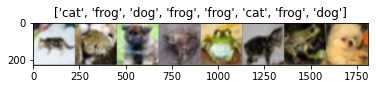

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT  
    for i in range(0, nqubits - 1, 2): # Loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1,2): # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [ ]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)
        
        # Embed features in the quantum node
        RY_layer(q_in)
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k+1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

In [ ]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, len(filtered_classes))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            
            # Apply the quantum circuit to each element of the batch, and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

In [ ]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

if quantum:
    model_hybrid.fc = Quantumnet()

elif classical_model == '512_n':
    model_hybrid.fc = nn.Linear(512,len(filtered_classes))

elif classical_model == '512_nq_n':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits),torch.nn.ReLU(),nn.Linear(n_qubits, len(filtered_classes))) 

elif classical_model == '551_512_n':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, len(filtered_classes)))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=3, gamma=gamma_lr_scheduler)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')
        for epoch in range(num_epochs):
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    # Set model to training mode
                    # scheduler.step()
                    model.train() 
                    scheduler.step()
                else:
                    # Set model to evaluate mode
                    model.eval()   
                
                # Iteration loop
                running_loss = 0.0
                running_corrects = 0
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, cifar_labels in dataloaders[phase]:
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = torch.tensor(labels_to_filtered(cifar_labels))
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    
                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.requires_grad = True
                            loss.backward()
                            optimizer.step()
                            
                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1
                
                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}             '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))
                
                # Check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss
        
        # Print final results             
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        return model

In [ ]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs)

Training started:
Phase: train Epoch: 1/3 Loss: 1.1347 Acc: 0.4773             
Phase: val   Epoch: 1/3 Loss: 1.0969 Acc: 0.5005             
Phase: train Epoch: 2/3 Loss: 1.1391 Acc: 0.4731             
Phase: val   Epoch: 2/3 Loss: 1.0979 Acc: 0.5015             
Phase: train Epoch: 3/3 Loss: 1.1341 Acc: 0.4768             
Phase: val   Epoch: 3/3 Loss: 1.0768 Acc: 0.5020             
Training completed in 42m 1s
Best test loss: 1.0768 | Best test accuracy: 0.5020


In [ ]:
if quantum:
        torch.save(model_hybrid.state_dict(), 
            'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
else:
        torch.save(model_hybrid.state_dict(), 
            'classical_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
print("Model state_dict saved.")

Model state_dict saved.


In [ ]:
if quantum:
    model_hybrid.load_state_dict(torch.load(
        'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
    )
                                 
else:
    model_hybrid.load_state_dict(torch.load(
        'classical_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
    )

In [ ]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['val'] // batch_size
it = 0
model_hybrid.eval()

# Testing loop
for inputs, cifar_labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = torch.tensor(labels_to_filtered(cifar_labels))
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it+1,n_batches+1), end='\r', flush=True)
    it += 1
                    
# Print final results
epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects / dataset_sizes['val']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))


Test Loss: 1.0768 Test Acc: 0.5020        


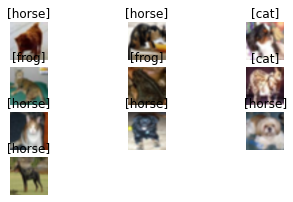

In [ ]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, cifar_labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = torch.tensor(labels_to_filtered(cifar_labels))
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(filtered_classes[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
        
visualize_model(model_hybrid, num_images=10)